In [456]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

with open('markov-to-transformers/data/names.txt', 'r') as f:
    names = f.read().splitlines()

In [194]:
chrs = {ch for name in names for ch in name}
chrs.add('.')
i_to_s = {i: chr for i, chr in enumerate(sorted(chrs))}
s_to_i = {v: k for k, v in i_to_s.items()}

In [379]:
block_size = 3
X, Y = [], []

for name in names:
    #print(name)
    name = f"{name}." 
    context = [0] * block_size # add as many start tokens as block size
    for ch in name:
        X.append(context)
        Y.append(s_to_i[ch])
        #print(f"{''.join([i_to_s[w] for w in context])} --> {ch}")
        context = context[1:] + [s_to_i[ch]]
    #print('--------')
X = torch.tensor(X) # inputs to the neural net
Y = torch.tensor(Y) # labels (ground truth)

In [117]:
for row_x, row_y in zip(X[:10], Y[:10]):
    print(f"{[val.item() for val in row_x]}[{''.join([i_to_s[val.item()] for val in row_x])}] ---> ",end='')
    print(f"[{row_y.item()}][{i_to_s[row_y.item()]}]")
X.shape, Y.shape

[0, 0, 0][...] ---> [5][e]
[0, 0, 5][..e] ---> [13][m]
[0, 5, 13][.em] ---> [13][m]
[5, 13, 13][emm] ---> [1][a]
[13, 13, 1][mma] ---> [0][.]
[0, 0, 0][...] ---> [15][o]
[0, 0, 15][..o] ---> [12][l]
[0, 15, 12][.ol] ---> [9][i]
[15, 12, 9][oli] ---> [22][v]
[12, 9, 22][liv] ---> [9][i]


(torch.Size([32, 3]), torch.Size([32]))

In [ ]:
C = torch.randn((27, 2)) # embeddings for each character a to z + '.'
emb = C[X] # retrieve embedding vector for each value in X. for each word: tensor(tensor('...'), tensor('..e'), tensor('.em'), ...)
# ps. pytorch indexing is awesome
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [298]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [312]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [330]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs.shape

torch.Size([32, 27])

In [335]:
loss = -probs[torch.arange(32), Y].log().mean() # NLL
loss

tensor(15.4113)

In [331]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

---

In [ ]:
import random 
random.seed(42)

In [517]:
def build_dataset(names):
    ''' Builds a 80/10/10 dataset with each training data point in `block_size` dimensions.'''

    block_size = 3
    X, Y = [], []
    for name in names:
        #print(name)
        name = f"{name}." 
        context = [0] * block_size # add as many start tokens as block size
        for ch in name:
            X.append(context)
            Y.append(s_to_i[ch])
            #print(f"{''.join([i_to_s[w] for w in context])} --> {ch}")
            context = context[1:] + [s_to_i[ch]]
        #print('--------')
    X = torch.tensor(X) # inputs to the neural net
    Y = torch.tensor(Y) # labels (ground truth)
    return X, Y

random.shuffle(names)
n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

Xtr, Ytr = build_dataset(names[:n1])
Xval, Yval = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

assert (len([ch for name in names for ch in name]) + len(names)) == sum((len(Ytr), len(Yval),len(Yte))),\
'Train/test/valid set size mismatch.'

In [538]:
Xtr.shape, Ytr.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [563]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True
    
print(f"Number of parameters: {sum(p.nelement() for p in params)}")

Number of parameters: 11897


In [562]:
stepi = []
lossi = []

In [572]:
for i in range(50000):

    # construct a minibatch 
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    print(('-' if i % 1000 == 0 else ''),end='')
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    #update
    for p in params:
        p.data += -0.01 * p.grad

    #track steps
    lossi.append(loss.log10().item())
    stepi.append(i)

print(f"\nTrained for {i+1} epochs.\nloss:{loss.item()}")

--------------------------------------------------
Trained for 50000 epochs.
loss:2.3802831172943115


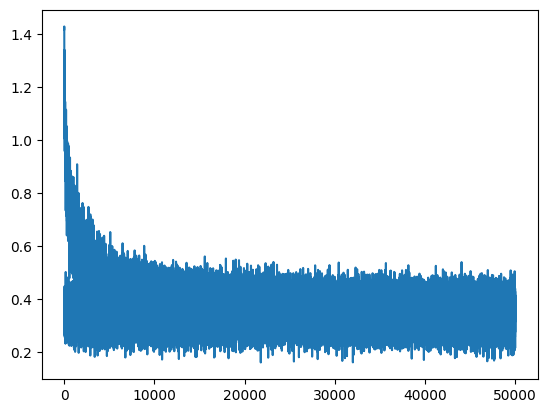

In [573]:
plt.plot(stepi, lossi)

In [574]:
# forward pass to calculate validation loss
emb = C[Xval]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
print(f"validation loss: {loss.item()}")

# forward pass to calculate test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(f"test loss: {loss.item()}")

validation loss: 2.2237846851348877
test loss: 2.230931043624878


In [659]:

for i in range(5):
    context = [0] * block_size
    word = ''
    while True:
        emb = C[context]
        h = torch.tanh(emb.view(-1, C.shape[1] * X.shape[1]) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        # 1, 30 ; 30, 200 -> 30, 200 ; 200, 27 -> 30, 27
        pred = torch.multinomial(probs, 1).item()
        context = context[1:] + [pred]
        if context[-1] == 0:
            break
        word += i_to_s[context[-1]]
    print(word)

emen
keyla
noft
kaira
villa
